In [ ]:
# %% [markdown]
"""
# Clustering Sémantique de Tickets Jira
**16 000 tickets | Multilingue FR/EN | Optimisation avancée**
"""
# %%
# %% [markdown]
"""
## 1. Configuration Initiale
**Optimisation mémoire et reproductibilité**
"""
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import gc
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.metrics import silhouette_score
from keybert import KeyBERT
from tqdm.auto import tqdm
import os

# Configuration globale
BATCH_SIZE = 300
N_COMPONENTS = 15
MIN_CLUSTER_SIZE = 50
SEED = 42
os.makedirs('./cache', exist_ok=True)

# %% [markdown]
"""
## 2. Prétraitement Intelligent
**Préservation des négations et termes techniques**
"""
# %%
def enhanced_clean(text):
    """Nettoyage amélioré préservant le sens"""
    if pd.isna(text):
        return ""
    
    # Protection des négations (regex multilingue)
    text = re.sub(
        r'\b(not|n\'t|no|ne\s+pas|non|aucun|without)\b\s+(\w+)', 
        r'\1_\2', 
        text, 
        flags=re.IGNORECASE
    )
    
    # Nettoyage de base
    text = text.lower().strip()
    text = re.sub(r'[^\w\s_-]', ' ', text)  # Garde les tirets
    text = re.sub(r'\s+', ' ', text)
    
    return text

# %% [markdown]
"""
## 3. Chargement des Données
**Gestion efficace de la mémoire**
"""
# %%
def load_jira_data(path):
    """Charge et nettoie les données Jira"""
    with tqdm(total=1, desc="📂 Chargement données") as pbar:
        df = pd.read_csv(
            path,
            usecols=['Summary'],
            dtype={'Summary': 'string'},
            engine='c'
        )
        df['Summary'] = df['Summary'].fillna('').apply(enhanced_clean)
        df = df[df['Summary'].str.len() > 3]  # Garde les mots courts techniques
        pbar.update(1)
    
    print(f"Exemples nettoyés:\n{df.sample(3, random_state=SEED)}\n")
    return df

# %% [markdown]
"""
## 4. Génération d'Embeddings
**Modèle multilingue performant**
"""
# %%

# %% [markdown]
"""
## 5. Clustering Hiérarchique
**Combinaison UMAP + HDBSCAN optimisée**
"""
# %%
def advanced_clustering(embeddings):
    """Pipeline de clustering amélioré"""
    # Réduction dimensionnelle
    umap = UMAP(
        n_components=N_COMPONENTS,
        n_neighbors=30,
        min_dist=0.1,
        metric='cosine',
        low_memory=True,
        random_state=SEED
    )
    umap_embeds = umap.fit_transform(embeddings)
    
    # Clustering densité
    clusterer = HDBSCAN(
        min_cluster_size=MIN_CLUSTER_SIZE,
        min_samples=5,
        cluster_selection_epsilon=0.15,
        metric='euclidean',
        prediction_data=True,
        memory='./cache'
    )
    clusters = clusterer.fit_predict(umap_embeds)
    
    # Post-processing: Fusion des petits clusters
    unique, counts = np.unique(clusters, return_counts=True)
    small_clusters = unique[counts < MIN_CLUSTER_SIZE]
    for sc in small_clusters:
        clusters[clusters == sc] = -1
    
    return clusters, umap_embeds

# %% [markdown]
"""
## 6. Évaluation Robuste
**Métriques fiables et visualisation**
"""
# %%
def evaluate_model(embeddings, clusters, umap_embeds):
    """Évaluation complète avec gestion des erreurs"""
    results = {}
    
    # Silhouette Score
    sample_size = min(3000, len(clusters))
    sample_idx = np.random.choice(len(clusters), sample_size, replace=False)
    results['Silhouette'] = silhouette_score(umap_embeds[sample_idx], clusters[sample_idx])
    
    # Analyse clusters
    unique_clusters = set(clusters) - {-1}
    results.update({
        'Clusters': len(unique_clusters),
        'Bruit (%)': np.mean(clusters == -1) * 100,
        'Taille moyenne': np.mean([np.sum(clusters == c) for c in unique_clusters])
    })
    
    # Visualisation
    plt.figure(figsize=(15, 6))
    plt.subplot(121)
    pd.Series(clusters).value_counts().plot(kind='bar', logy=True)
    plt.title('Distribution des Clusters')
    
    plt.subplot(122)
    plt.scatter(umap_embeds[:,0], umap_embeds[:,1], c=clusters, cmap='Spectral', s=2, alpha=0.5)
    plt.title('Projection UMAP')
    
    plt.tight_layout()
    plt.show()
    
    return results

# %% [markdown]
"""
## 7. Extraction de Thématiques
**Mots-clés significatifs par cluster**
"""
# %%
def extract_keywords(df, clusters):
    """Extraction de topics améliorée"""
    kw_model = KeyBERT('paraphrase-multilingual-MiniLM-L12-v2')
    
    topics = {}
    for cluster in tqdm(sorted(np.unique(clusters)), desc="🔍 Extraction des topics"):
        if cluster == -1:
            continue
            
        texts = df[clusters == cluster]['Summary'].tolist()
        if len(texts) < 10:  # Ignore les très petits clusters
            continue
            
        # Extraction avec diversité
        keywords = kw_model.extract_keywords(
            ' '.join(texts),
            keyphrase_ngram_range=(1, 3),
            use_mmr=True,
            diversity=0.7,
            top_n=5
        )
        topics[cluster] = [kw[0] for kw in keywords]
    
    # Affichage des résultats
    print("\nThématiques par cluster:")
    for cluster, kws in topics.items():
        print(f"Cluster {cluster}: {', '.join(kws)}")
    
    return topics

# %% [markdown]
"""
## 8. Pipeline Complet
"""
# %%
# Chargement des données
df = load_jira_data('C:/Users/my.kassem/Desktop/exploratory data analysis/df_filtre_status_type_description_resolution_copy.csv')


# Extraction des thèmes
_ = extract_keywords(df, clusters)

# Sauvegarde
df.to_csv('jira_clusters_advanced.csv', index=False)

📂 Chargement données:   0%|          | 0/1 [00:00<?, ?it/s]

Exemples nettoyés:
                                                 Summary
10329  les champs de type file ne sont plus visibles ...
12018  différence de comportement lors de l appel d u...
9196    packaging package deployement error tolerance...



modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

c:\Users\my.kassem\Desktop\Intelligent_analysis_of_JIRA_tickets\.venv\lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\my.kassem\Desktop\Intelligent_analysis_of_JIRA_tickets\Tickets clustering\Pipeline_Ticket_Clustering\cache\models--sentence-transformers--paraphrase-multilingual-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-fo

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

TypeError: range() takes no keyword arguments

In [5]:
def generate_semantic_embeddings(texts):
    """Génère des embeddings sémantiques de qualité"""
    model = SentenceTransformer(
        'sentence-transformers/paraphrase-multilingual-mpnet-base-v2',
        device='cpu',
        cache_folder='./cache'
    )
    
    embeddings = []
    # Correction ici : séparer les paramètres range() et tqdm()
    for i in tqdm(range(0, len(texts), BATCH_SIZE), desc="🔧 Génération embeddings"):
        batch = texts[i:i+BATCH_SIZE]
        emb = model.encode(
            batch,
            show_progress_bar=False,
            convert_to_numpy=True,
            normalize_embeddings=True,
            batch_size=64
        )
        embeddings.append(emb)
        gc.collect()
    
    return np.vstack(embeddings)

In [7]:
# Génération des embeddings
embeddings = generate_semantic_embeddings(df['Summary'].tolist())

🔧 Génération embeddings:   0%|          | 0/54 [00:00<?, ?it/s]

In [8]:
# Clustering
clusters, umap_embeds = advanced_clustering(embeddings)
df['Cluster'] = clusters

c:\Users\my.kassem\Desktop\Intelligent_analysis_of_JIRA_tickets\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


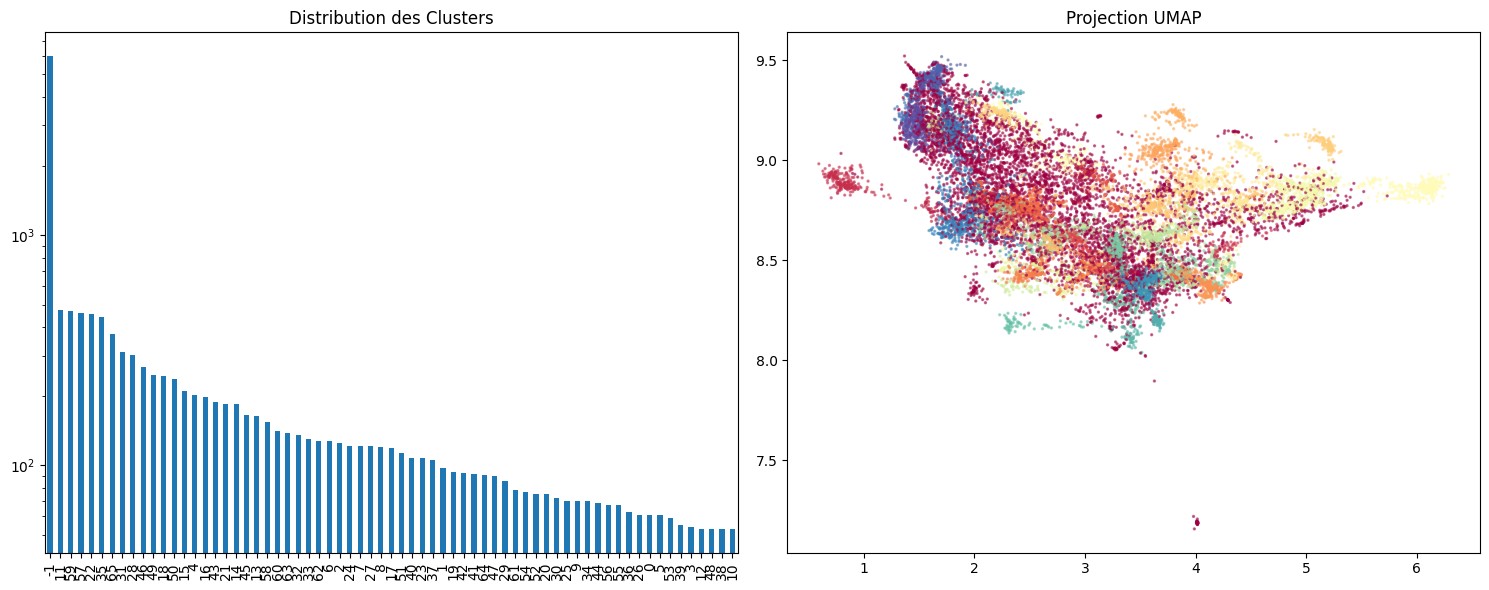


📊 Résultats finaux:
- Silhouette: 0.09061070531606674
- Clusters: 66
- Bruit (%): 37.63
- Taille moyenne: 151.00


In [9]:
# Évaluation
results = evaluate_model(embeddings, clusters, umap_embeds)
print("\n📊 Résultats finaux:")
for k, v in results.items():
    print(f"- {k}: {v:.2f}" if isinstance(v, float) else f"- {k}: {v}")